# 09_reporting_figures_and_tables — Paper-ready Outputs
This notebook compiles **metrics, figures, and tables** for the report/thesis.

**Inputs**
- `final_metrics.csv` (from 08)
- `bn_inference.csv` (from 07)
- `decision_recommendations.csv` (from 06)
- `predictions_test.csv` (from 05)
- `master_with_topics.csv` or `features_daily.csv`

**Outputs**
- `figures/forecast_test_highres.png`
- `figures/risk_highload_rule_vs_bn_highres.png`
- `figures/decision_timeline_highres.png`
- `results_table.csv`, `results_table.tex`


## 1) Imports & paths

In [1]:

import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,4)

FIG_DIR = Path("figures"); FIG_DIR.mkdir(exist_ok=True)

METRICS_PATH = "final_metrics.csv"
BN_PATH = "bn_inference.csv"
RULE_PATH = "decision_recommendations.csv"
PRED_PATH = "predictions_test.csv"
FEAT_PATH = "master_with_topics.csv"  # or features_daily.csv

for p in [METRICS_PATH, BN_PATH, RULE_PATH, PRED_PATH, FEAT_PATH]:
    print(Path(p).resolve())

C:\Users\abhis\Desktop\Big Data\Hydropower decision support system\final_metrics.csv
C:\Users\abhis\Desktop\Big Data\Hydropower decision support system\bn_inference.csv
C:\Users\abhis\Desktop\Big Data\Hydropower decision support system\decision_recommendations.csv
C:\Users\abhis\Desktop\Big Data\Hydropower decision support system\predictions_test.csv
C:\Users\abhis\Desktop\Big Data\Hydropower decision support system\master_with_topics.csv


## 2) Load data

In [3]:

## 2) Load data

def rd(p):
    fp = Path(p)
    if not fp.exists():
        return None
    # peek header
    header = pd.read_csv(fp, nrows=0).columns
    if 'date' in header:
        return pd.read_csv(fp, parse_dates=['date'])
    else:
        return pd.read_csv(fp)

metrics = rd(METRICS_PATH)
bn = rd(BN_PATH)
rule = rd(RULE_PATH)
pred = rd(PRED_PATH)
feat = rd(FEAT_PATH)

print('Loaded:', {
    'metrics': metrics is not None,
    'bn': bn is not None,
    'rule': rule is not None,
    'pred': pred is not None,
    'feat': feat is not None
})

(metrics.head(2) if metrics is not None else None)


Loaded: {'metrics': True, 'bn': True, 'rule': True, 'pred': True, 'feat': True}


,model,rmse,mae,mape_%,pi_95_coverage_%
0,GP (non-load),129.282911,101.159871,5.937984,91.242938


## 3) Forecast: Actual vs GP with PI (high-res figure)

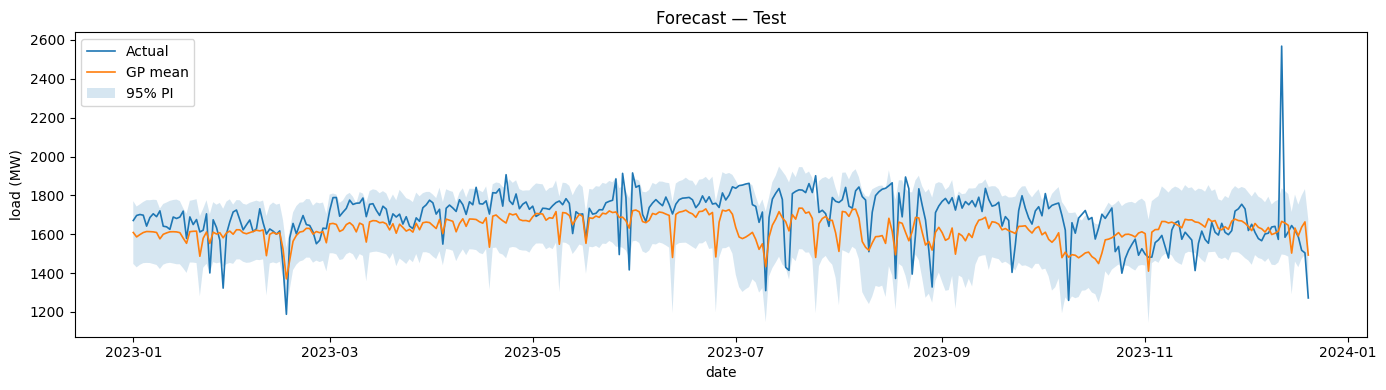

Saved figures\forecast_test_highres.png


In [4]:

if pred is not None and {'date','y_true','gpr_mean'}.issubset(pred.columns):
    p = pred.sort_values('date')
    plt.figure(figsize=(14,4))
    plt.plot(p['date'], p['y_true'], label='Actual', lw=1.2)
    plt.plot(p['date'], p['gpr_mean'], label='GP mean', lw=1.2)
    if 'gpr_std' in p.columns:
        lo, up = p['gpr_mean']-1.96*p['gpr_std'], p['gpr_mean']+1.96*p['gpr_std']
        plt.fill_between(p['date'], lo, up, alpha=0.18, label='95% PI')
    plt.title('Forecast — Test')
    plt.xlabel('date'); plt.ylabel('load (MW)'); plt.legend()
    out = FIG_DIR/'forecast_test_highres.png'
    plt.tight_layout(); plt.savefig(out, dpi=220); plt.show()
    print('Saved', out)

## 4) Rule vs BN — High‑load risk (high-res figure)

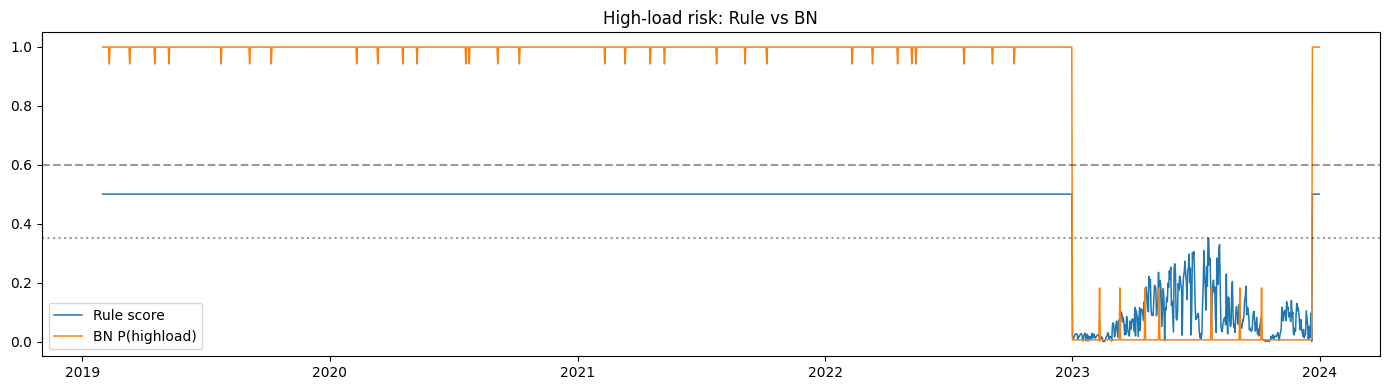

Saved figures\risk_highload_rule_vs_bn_highres.png


In [5]:

if (rule is not None) and (bn is not None):
    merged = rule.merge(bn, on='date', how='inner')
    if 'P(RiskHighLoad=1)' in merged.columns and 'risk_highload' in merged.columns:
        plt.figure(figsize=(14,4))
        plt.plot(merged['date'], merged['risk_highload'], label='Rule score', lw=1.1)
        plt.plot(merged['date'], merged['P(RiskHighLoad=1)'], label='BN P(highload)', lw=1.1)
        plt.axhline(0.60, color='k', ls='--', alpha=0.4); plt.axhline(0.35, color='k', ls=':', alpha=0.4)
        plt.title('High‑load risk: Rule vs BN'); plt.legend()
        out = FIG_DIR/'risk_highload_rule_vs_bn_highres.png'
        plt.tight_layout(); plt.savefig(out, dpi=220); plt.show()
        print('Saved', out)

## 5) Decision timeline (color-coded)

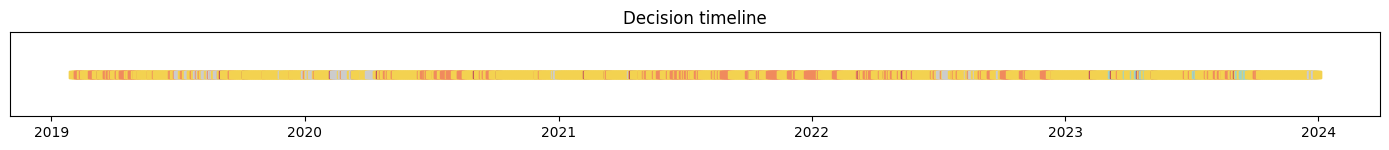

Saved figures\decision_timeline_highres.png


In [6]:

if rule is not None:
    d = rule[['date','decision']].copy()
    order = ['Normal operations','Monitor inflows; pre-position spillway crew',
             'Monitor shortfall','Monitor peak hour support',
             'Spill advisory & downstream warning','Shortfall mitigation (imports/DR)',
             'Prepare peak management (imports/demand response)',
             'Defer maintenance; keep units available','Review maintenance schedule']
    # Map to levels for color
    palette = {
        'Normal operations':'#9fd3c7',
        'Monitor inflows; pre-position spillway crew':'#f3d250',
        'Monitor shortfall':'#f3d250',
        'Monitor peak hour support':'#f3d250',
        'Review maintenance schedule':'#f3d250',
        'Spill advisory & downstream warning':'#f08a5d',
        'Shortfall mitigation (imports/DR)':'#f08a5d',
        'Prepare peak management (imports/demand response)':'#f08a5d',
        'Defer maintenance; keep units available':'#b83b5e'
    }
    d['color'] = d['decision'].map(palette).fillna('#cccccc')
    plt.figure(figsize=(14,1.6))
    plt.scatter(d['date'], [1]*len(d), c=d['color'], s=25, marker='s')
    plt.yticks([]); plt.title('Decision timeline')
    out = FIG_DIR/'decision_timeline_highres.png'
    plt.tight_layout(); plt.savefig(out, dpi=220); plt.show()
    print('Saved', out)

## 6) Results table (CSV + LaTeX)

In [7]:

# Start from metrics; add simple BN summary if available
rows = []
if metrics is not None:
    for _, r in metrics.iterrows():
        rows.append([r['model'], r['rmse'], r['mae'], r['mape_%'], r.get('pi_95_coverage_%', np.nan)])

# BN alert summary (optional)
bn_sum = None
if bn is not None:
    bn_sum = {
        'bn_avg_P_highload': float(bn['P(RiskHighLoad=1)'].mean()) if 'P(RiskHighLoad=1)' in bn.columns else np.nan,
        'bn_avg_P_shortfall': float(bn['P(RiskShortfall=1)'].mean()) if 'P(RiskShortfall=1)' in bn.columns else np.nan,
        'bn_avg_P_spill': float(bn['P(RiskSpill=1)'].mean()) if 'P(RiskSpill=1)' in bn.columns else np.nan,
    }

tbl = pd.DataFrame(rows, columns=['model','rmse','mae','mape_%','pi_95_coverage_%'])
tbl.to_csv('results_table.csv', index=False)
print('Saved results_table.csv')
tbl

Saved results_table.csv


,model,rmse,mae,mape_%,pi_95_coverage_%
0,GP (non-load),129.282911,101.159871,5.937984,91.242938


In [8]:

# Minimal LaTeX export
def df_to_latex(df, caption='Results', label='tab:results'):
    cols = df.columns
    header = ' & '.join(cols) + ' \\'
    lines = [ '\begin{table}[h]',
              '\centering',
              f'\caption{{{caption}}}',
              f'\label{{{label}}}',
              '\begin{tabular}{' + 'l' + 'r'*(len(cols)-1) + '}',
              '\toprule' if True else '',
              header,
              '\midrule' if True else '' ]
    for _, r in df.iterrows():
        row = ' & '.join(str(x) for x in r.values) + ' \\'
        lines.append(row)
    lines += ['\bottomrule' if True else '', '\end{tabular}', '\end{table}']
    return '\n'.join(lines)

latex_str = df_to_latex(tbl, caption='Forecast metrics and coverage', label='tab:metrics')
with open('results_table.tex','w',encoding='utf-8') as f:
    f.write(latex_str)
print('Saved results_table.tex')

Saved results_table.tex
